# Probability Distribution of FFT Coefficients

Attempt to predict the distrubtion of the fft coefficients.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2,norm
from scipy.stats import kstest

import src.signal.signal as sgl
import src.signal.pulse as pls

In [2]:

def standardize(dft):
    #standardizes complext vector dft
    r = dft.real
    c = dft.imag
    r_std = (r-r.mean())/r.std(ddof=1)
    c_std = (c-c.mean())/r.std(ddof=1)
    std = r_std + c_std*1j
    return std

## 1. Verify FFT implementation

In [3]:
def coef_array(n):
    def coef_vector(n, k):
        m = np.arange(n)
        expn = np.exp(-2.0j*np.pi*m*k/n)
        return expn
    coefs = np.array([coef_vector(n,k)for k in range(n)])    
    return coefs

def dft(sig, coefs):

    fourier = coefs.dot(sig.reshape(-1,1)).reshape(-1)
    
    return fourier

In [5]:
tsamp = 1.0/1024.0
sigdur = 1.0 # second
nsamp = int(sigdur/tsamp)

noiseprops={"noise_mu":0, "noise_sigma":1} #default white noise
sig = sgl.Signal(noiseprops=noiseprops,tsamp=tsamp).get_signal(sigdur=sigdur)
coefs = coef_array(nsamp)
dft_test = dft(sig, coefs)
dft_np = np.fft.fft(sig)
np.allclose(dft_test, dft_np)

True

The cell above shows that the hand calculation of the forward dft matches that of the numpy implementation.

## Linear Combinations of Random Variables

Let $x_1,\ x_2,\ ...\ x_n$ be IID $ X\ \sim\ N(\mu, \sigma^2)$
and
$$ y = \sum_{i=1}^Na_ix_i
$$
Then:
$$
E(y) = \sum_{i=1}^Na_iE(x_i)
$$
and
$$
var(y) = \sum_{i=1}^Na_i^2var(x_i)\ + \  2\cdot\mathop{\sum_{i}\sum_{j}}_{i>j}a_i a_k \cdot cov(x_i, x_j)
$$
Since the $x_i$ terms are IID, the $cov(x_i, x_j)$ is zero, so the term on the right of the equation above vanishes. The equation simplifies to:
$$
var(y) = \sum_{i=1}^Na_i^2var(x_i)
$$


The $\mathbf{a}_i$ in the equation above is the $i^{th}$ row vector in the coefficient matrix previously computed. For the fourier coefficient $f_k$:
$$
f_k = \mathbf{a}_{k}\bullet signal
$$
which is
$$
f_k = \sum_{j=0}^{N-1}a_{k,j}\cdot signal_j
$$
so that
$$
E(f_k) = \sum_{j=0}^{N-1}a_{k,j}\cdot E(signal_j)
$$
and
$$
var(f_k) = \sum_{j=0}^{N-1}a_{k,j}^2\cdot var(signal_j)
$$

Since the samples of $signal$ are IID, $E(signal_j)=\mu_{signal}$ and $var(signal_j)=\sigma_{signal}^2$ the above equations simplify to:
$$
E(f_k) = \mu_{signal} \sum_{j=0}^{N-1}a_{k,j}
$$
and
$$
var(f_k) = \sigma_{signal}^2 \sum_{j=0}^{N-1}a_{k,j}^2
$$

## Predict Coefficient Variance

In [8]:
def run_trial(sigdur, coef_number, noiseprops, norm=None):
    sig = sgl.Signal(noiseprops=noiseprops,tsamp=tsamp).get_signal(sigdur=sigdur)
    dft = np.fft.rfft(sig, norm=norm)
    return dft[coef_number]

In [10]:
def mu_sig_pred(n, k, noise_mu, noise_sigma):
    coefs = coef_array(n)
    c_real = coefs[k].real
    c_imag = coefs[k].imag
    mu_pred = noise_mu*(c_real.sum()+c_imag.sum()*1j)

    sig_r = np.sqrt((noise_sigma**2)*(c_real**2).sum())
    sig_i = np.sqrt((noise_sigma**2)*(c_imag**2).sum())
    sig_pred = sig_r + sig_i*1j

    return mu_pred, sig_pred




In [11]:
#run a bunch of experiments and look at the distrubtion of a randomly picked coefficient
NTRIALS = 10000
SIGDUR  = 1.0 #second
k = 24 # let's look at this coeff
noiseprops={"noise_mu":0, "noise_sigma":1} #default white noise

coef_k = np.array([run_trial(SIGDUR, k, noise_mu=noiseprops) for i in range(NTRIALS)])
preds = mu_sig_pred(SIGDUR, k, noiseprops['noise_mu'], noiseprops['noise_sigma'])
#separate the real  and imaginary parts for ease of plotting below
pred_dict = {'Real':[preds[0].real, preds[1].real], 'Imaginary':[preds[0].imag, preds[1].imag]}

TypeError: run_trial() got an unexpected keyword argument 'noise_mu'

In [10]:
pred_dict

{'Real': [9.381384558082573e-14, 22.627416997969515],
 'Imaginary': [8.021361352916756e-14, 22.627416997969526]}

In [11]:
preds[0].real

9.381384558082573e-14

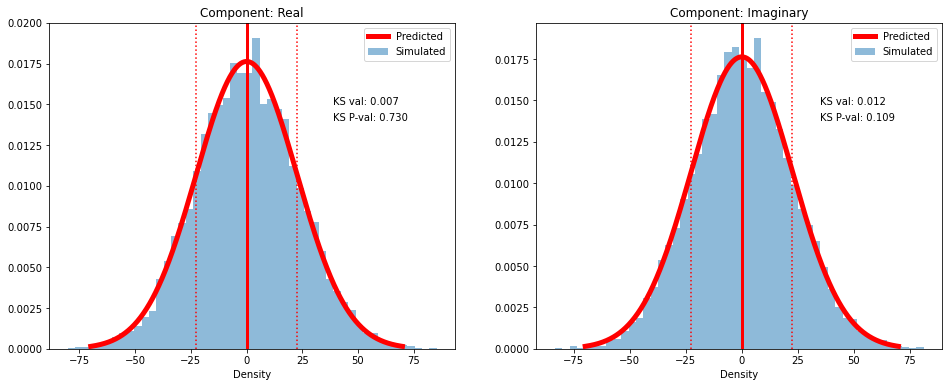

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(16,6))
for ax, c, p  in zip(axs, [coef_k.real, coef_k.imag], pred_dict):

    m = pred_dict[p][0]
    sd = pred_dict[p][1]
    #create normal density function based on predicted paramaters
    xx = np.linspace(norm.ppf(0.001, loc=m, scale=sd), norm.ppf(0.999, loc=m, scale=sd), SIGLEN)
    pdf = norm.pdf(xx, loc=m, scale=sd)

    #Kolomogorov-Smirnov Test for normality:
    ks_v, ks_p = kstest(c,'norm',[m,sd])

    zz = ax.hist(c, bins=50, density=True, alpha=0.5, label='Simulated')

    ax.plot(xx, pdf, lw=5, color='red', label='Predicted')
    ax.axvline(m, lw=3, color='red')
    ax.axvline(m-sd, ls=':', color='red')
    ax.axvline(m+sd, ls=':', color='red')
    ax.text(0.7, 0.75, f'KS val: {ks_v:.3f}',transform=ax.transAxes)
    ax.text(0.7, 0.70, f'KS P-val: {ks_p:.3f}',transform=ax.transAxes)

    ax.set_title(f'Component: {p}')
    ax.legend(loc='upper right')
    ax.set_xlabel('Density')

Pretty good evidence that the coefficients are normally distributed and that we can predict and variance.

## Coefficient Matrix as Basis Matrix

In [13]:
coefs = coef_array(SIGLEN)
coefs.shape

(1024, 1024)

In [14]:
((coefs.imag/np.sqrt(512))**2).sum(axis=0)

array([0., 1., 1., ..., 1., 1., 1.])

In [15]:
((coefs/np.sqrt(512))**2).sum(axis=0)

array([ 2.00000000e+00+0.00000000e+00j, -1.23165367e-16+3.45148985e-17j,
       -5.39932682e-17-2.28766658e-16j, ...,
        3.89861754e-14-3.01355349e-15j,  1.83773352e-13+1.61971199e-14j,
       -4.35328856e-15-1.26897496e-14j])

In [16]:
norm_r = coefs.real/np.sqrt(512)
norm_i = coefs.imag/np.sqrt(512)

In [17]:
(norm_r.T**2).sum(axis=1)

array([2., 1., 1., ..., 1., 1., 1.])

In [18]:
norm_i[:,20].dot(norm_i[:,21])

1.0321604682062002e-15

In [19]:
#run a bunch of experiments and look at the distrubtion of a randomly picked coefficient

#np.random.seed(1234)
NTRIALS = 10000
SIGLEN = 1024
k = 66 # let's look at this coeff
noise_mu=10
noise_sigma=60

#note scaling by sqrt(2) and norm = ortho parameter; need to divide by noise_sigma to make standard normal
coef_k = np.array([run_trial(SIGLEN, k, noise_mu=noise_mu, noise_sigma=noise_sigma, norm='ortho') for i in range(NTRIALS)])*np.sqrt(2.)/noise_sigma

#ignore these
#preds = mu_sig_pred(SIGLEN, k, noise_mu, noise_sigma)
#separate the real  and imaginary parts for ease of plotting below
#pred_dict = {'Real':[preds[0].real, preds[1].real], 'Imaginary':[preds[0].imag, preds[1].imag]}

pred_dict = {'Real':[0,1], 'Imaginary':[0,1]} #Standard Normal for this experiment

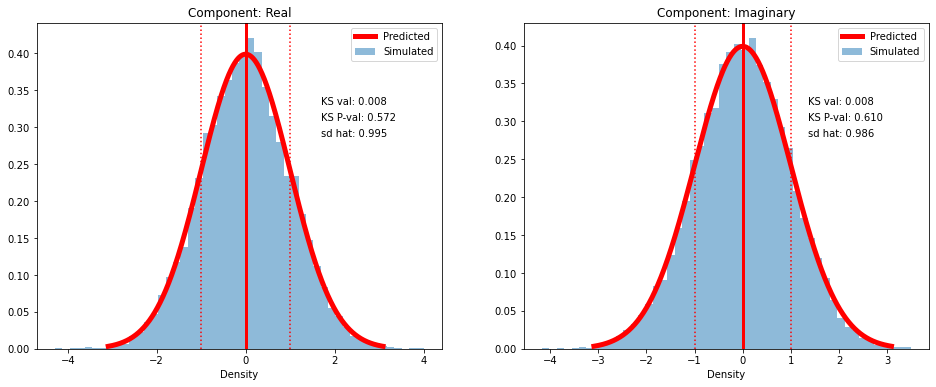

In [20]:

fig, axs = plt.subplots(ncols=2, figsize=(16,6))
for ax, c, p  in zip(axs, [coef_k.real, coef_k.imag], pred_dict):

    m = pred_dict[p][0]
    sd = pred_dict[p][1]
    #create normal density function based on predicted paramaters
    xx = np.linspace(norm.ppf(0.001, loc=m, scale=sd), norm.ppf(0.999, loc=m, scale=sd), SIGLEN)
    pdf = norm.pdf(xx, loc=m, scale=sd)

    #Kolomogorov-Smirnov Test for normality:
    ks_v, ks_p = kstest(c,'norm',[m,sd])

    zz = ax.hist(c, bins=50, density=True, alpha=0.5, label='Simulated')

    ax.plot(xx, pdf, lw=5, color='red', label='Predicted')
    ax.axvline(m, lw=3, color='red')
    ax.axvline(m-sd, ls=':', color='red')
    ax.axvline(m+sd, ls=':', color='red')
    ax.text(0.7, 0.75, f'KS val: {ks_v:.3f}',transform=ax.transAxes)
    ax.text(0.7, 0.70, f'KS P-val: {ks_p:.3f}',transform=ax.transAxes)
    ax.text(0.7, 0.65, f'sd hat: {c.std(ddof=1):.3f}',transform=ax.transAxes)
    
    ax.set_title(f'Component: {p}')
    ax.legend(loc='upper right')
    ax.set_xlabel('Density')

The figure above shows that when the input signal is IID $\sim N(\mu_{Signal}, \sigma_{Signal}^2)$, the Fourier coefficient $f_k$ returned by `np.fft.rfft(signal, norm='ortho')*np.sqrt(2.)` is $\sim N(0,\sigma_{Signal}^2)$. Need special handling of or to ignore the bias or DC frequency bin (bin 0).

## Chi Square Distribution of Coefficients

We show above the distribution individual Fourier coefficients to be $\sim N(0,\sigma_{Signal}^2)$.
Divding the coefficients by $\sigma_{Signal}$ will make them Standard Normal, i.e., $\sim N(0,1)$.
The sum of $N$ IID $N(0,1)$ is Chi-square distributed with $\nu=N$ degrees of freedom.

In [21]:
#show that squared abs value of coeff is sum of squares of real and imaginary components
np.allclose(coef_k.real**2+coef_k.imag**2, np.abs(coef_k)**2)

True

In [22]:
#run a bunch of experiments and look at the distrubtion of a randomly picked coefficient

#np.random.seed(1234)
NTRIALS = 10000
SIGLEN = 1024
k = 66 # let's look at this coeff
noise_mu=10
noise_sigma=60

#note scaling by sqrt(2) and norm = ortho parameter; need to divide by noise_sigma to make standard normal
coef_k = np.array([run_trial(SIGLEN, k, noise_mu=noise_mu, noise_sigma=noise_sigma, norm='ortho') for i in range(NTRIALS)])*np.sqrt(2.)/noise_sigma
pwr = np.power(np.abs(coef_k), 2.) # should be chi square nu=2

Text(0.5, 0, 'Normalized Power')

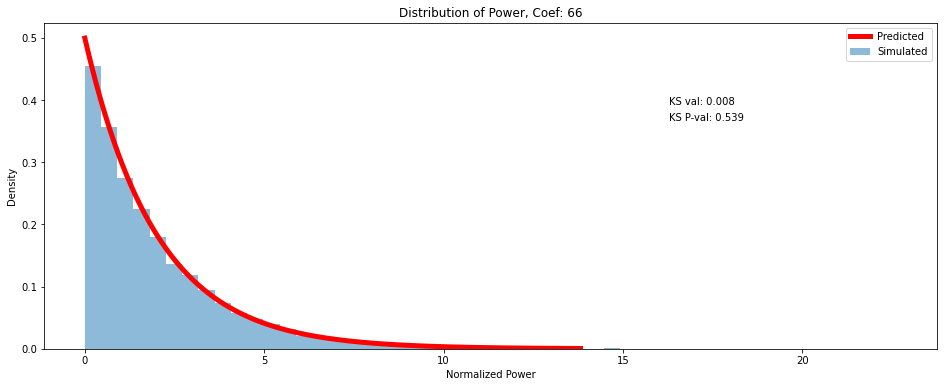

In [23]:
fig, ax = plt.subplots(ncols=1, figsize=(16,6))


dof=2
#create normal density function based on predicted paramaters
xx = np.linspace(chi2.ppf(0.001, dof), chi2.ppf(0.999, dof), SIGLEN)
pdf = chi2.pdf(xx, dof)

#Kolomogorov-Smirnov Test for normality:
ks_v, ks_p = kstest(pwr,'chi2',[2])

zz = ax.hist(pwr, bins=50, density=True, alpha=0.5, label='Simulated')

ax.plot(xx, pdf, lw=5, color='red', label='Predicted')
#ax.axvline(m, lw=3, color='red')
#ax.axvline(m-sd, ls=':', color='red')
#ax.axvline(m+sd, ls=':', color='red')
ax.text(0.7, 0.75, f'KS val: {ks_v:.3f}',transform=ax.transAxes)
ax.text(0.7, 0.70, f'KS P-val: {ks_p:.3f}',transform=ax.transAxes)
#ax.text(0.7, 0.65, f'sd hat: {c.std(ddof=1):.3f}',transform=ax.transAxes)

ax.set_title(f'Distribution of Power, Coef: {str(k)}')
ax.legend(loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Normalized Power')

## Distribution of Total (Normalized) Power

In [24]:
def run_pwr_trial(siglen,  noise_mu=0, noise_sigma=1, bias=False, fft=True):
    sig = gaussian_noise(siglen, noise_sigma=noise_sigma, noise_mu=noise_mu)
    if fft:
        dft = np.fft.rfft(sig, norm='ortho')*np.sqrt(2.)/noise_sigma #should be standard normal
    else:
        dft = (sig-noise_mu)/noise_sigma
    if bias:
        c_r = dft.real
        c_i = dft.imag
    else:
        c_r = dft.real[1:]
        c_i = dft.imag[1:]
    return np.sum(np.array([c_r, c_i])**2)

In [25]:
#run a bunch of experiments and look at the distrubtion of a randomly picked coefficient

#np.random.seed(1234)
NTRIALS = 20000
SIGLEN = 1024

noise_mu=10
noise_sigma=60
pwr_chi2 = np.array([run_pwr_trial(SIGLEN, noise_mu=noise_mu, noise_sigma=noise_sigma) for i in range(NTRIALS)])


Text(0.5, 0, 'Total Normalized Power')

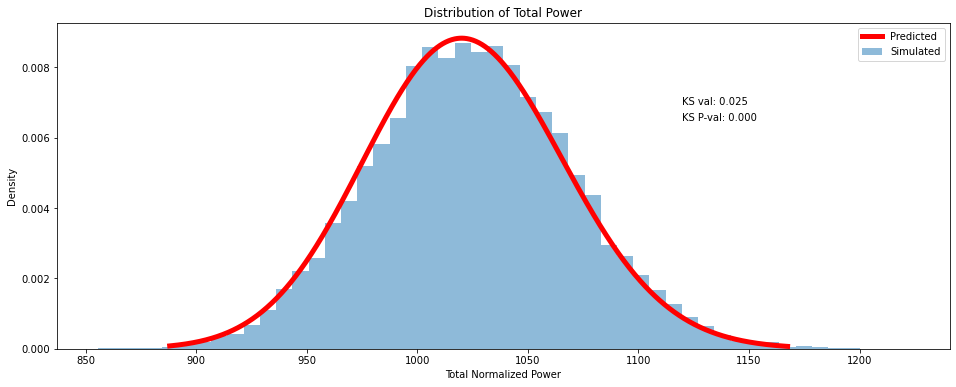

In [26]:
fig, ax = plt.subplots(ncols=1, figsize=(16,6))


dof=SIGLEN-2 # because we excluded the bias component
#create normal density function based on predicted paramaters
xx = np.linspace(chi2.ppf(0.001, dof), chi2.ppf(0.999, dof), SIGLEN)
pdf = chi2.pdf(xx, dof)

#Kolomogorov-Smirnov Test for normality:
ks_v, ks_p = kstest(pwr_chi2,'chi2',[dof])

zz = ax.hist(pwr_chi2, bins=50, density=True, alpha=0.5, label='Simulated')

ax.plot(xx, pdf, lw=5, color='red', label='Predicted')
#ax.axvline(m, lw=3, color='red')
#ax.axvline(m-sd, ls=':', color='red')
#ax.axvline(m+sd, ls=':', color='red')
ax.text(0.7, 0.75, f'KS val: {ks_v:.3f}',transform=ax.transAxes)
ax.text(0.7, 0.70, f'KS P-val: {ks_p:.3f}',transform=ax.transAxes)
#ax.text(0.7, 0.65, f'sd hat: {c.std(ddof=1):.3f}',transform=ax.transAxes)

ax.set_title(f'Distribution of Total Power')
ax.legend(loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Normalized Power')

In [27]:
#run a bunch of experiments and look at the distrubtion of a randomly picked coefficient

#np.random.seed(1234)
NTRIALS = 20000
SIGLEN = 1024

noise_mu=10
noise_sigma=60
pwr_chi2 = np.array([run_pwr_trial(SIGLEN, noise_mu=noise_mu, noise_sigma=noise_sigma, fft=False) for i in range(NTRIALS)])

Text(0.5, 0, 'Total Normalized Power')

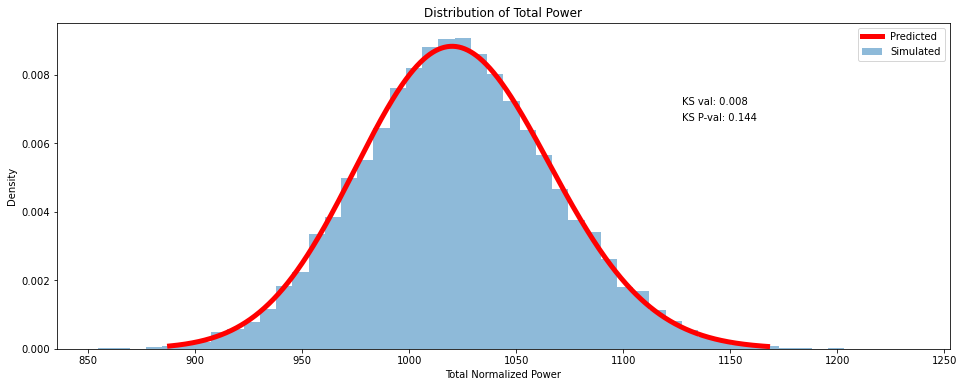

In [32]:
fig, ax = plt.subplots(ncols=1, figsize=(16,6))


dof=SIGLEN-2 # because we excluded the bias component
#create normal density function based on predicted paramaters
xx = np.linspace(chi2.ppf(0.001, dof), chi2.ppf(0.999, dof), SIGLEN)
pdf = chi2.pdf(xx, dof)

#Kolomogorov-Smirnov Test for normality:
ks_v, ks_p = kstest(pwr_chi2,'chi2',[dof])

zz = ax.hist(pwr_chi2, bins=50, density=True, alpha=0.5, label='Simulated')

ax.plot(xx, pdf, lw=5, color='red', label='Predicted')
#ax.axvline(m, lw=3, color='red')
#ax.axvline(m-sd, ls=':', color='red')
#ax.axvline(m+sd, ls=':', color='red')
ax.text(0.7, 0.75, f'KS val: {ks_v:.3f}',transform=ax.transAxes)
ax.text(0.7, 0.70, f'KS P-val: {ks_p:.3f}',transform=ax.transAxes)
#ax.text(0.7, 0.65, f'sd hat: {c.std(ddof=1):.3f}',transform=ax.transAxes)

ax.set_title(f'Distribution of Total Power')
ax.legend(loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Normalized Power')

The two graphs above illustrate that the sum of the squared real and imaginary Fourier coefficients **is not** distributed as Chi Square as I had expected. Why this is not the case will have to wait for a later day, suspicion is coefficients are not independent of one another as is necessary for the Chi Square distribution.

This observation has the following implications:
1. Can test whether a signal is Gaussian Noise by using Chi Square hypothesis test on the sum of the squared signal values.
2. Can test test individual fourier coefficients via Chi Square with $\nu=2$
3. Until further notice can't test the sum of the squared fourier coefficients 